In [27]:
dir="/content/drive/MyDrive/Colab Notebooks/computer-vision"
dir_data=dir+"/data"
imagenette_uri="https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"

def download(uri: str, path: str) -> bool:
  import requests
  import tarfile
  import os
  file = path + "/arch.tgz"
  if os.path.isfile(file):
    return True
  response = requests.get(imagenette_uri, stream=True)
  if response.status_code == 200:
    with open(file, 'wb') as f:
      f.write(response.raw.read())
    tar = tarfile.open(file)
    tar.extractall(path=path)
    tar.close()
    os.remove(file)
    return True
  else:
    return False

# Download and extract
# download(imagenette_uri, dir_data)

In [28]:
import numpy as np
from pathlib import Path
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet, efficientnet
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dir_path = Path(dir_data + '/imagenette2-160/val/')

def get_model(model_name):
    if model_name == 'vgg16':
        model = vgg16.VGG16(weights='imagenet')
    elif model_name == 'inception_v3':
        model = inception_v3.InceptionV3(weights='imagenet')
    elif model_name == 'resnet50':
        model = resnet50.ResNet50(weights='imagenet')
    elif model_name == 'mobilenet':
        model = mobilenet.MobileNet(weights='imagenet')
    elif model_name == 'efficientnet':
        model = efficientnet.EfficientNetB6(weights='imagenet')
    elif model_name == 'efficientnetB0':
        model = efficientnet.EfficientNetB0(weights='imagenet')
    elif model_name == 'efficientnetB1':
        model = efficientnet.EfficientNetB1(weights='imagenet')
    elif model_name == 'efficientnetB2':
        model = efficientnet.EfficientNetB2(weights='imagenet')
    elif model_name == 'efficientnetB3':
        model = efficientnet.EfficientNetB3(weights='imagenet')
    elif model_name == 'efficientnetB4':
        model = efficientnet.EfficientNetB4(weights='imagenet')
    elif model_name == 'efficientnetB5':
        model = efficientnet.EfficientNetB5(weights='imagenet')
    elif model_name == 'efficientnetB6':
        model = efficientnet.EfficientNetB6(weights='imagenet')
    elif model_name == 'efficientnetB7':
        model = efficientnet.EfficientNetB7(weights='imagenet')
    return model

def get_helper_module(model_name):
    if model_name == 'vgg16':
        return vgg16
    elif model_name == 'inception_v3':
        return inception_v3
    elif model_name == 'resnet50':
        return resnet50
    elif model_name == 'mobilenet':
        return mobilenet
    elif model_name.startswith('efficientnet'):
        return efficientnet

def get_model_instance(model_name):
  model = get_model(model_name)
  helper_module = get_helper_module(model_name)
  return model, helper_module

def get_generator(dir_path):
  valid_datagen = ImageDataGenerator(preprocessing_function=helper_module.preprocess_input)
  return valid_datagen.flow_from_directory(
        dir_path,
        shuffle=True, 
        seed=42, 
        target_size=model.input_shape[1:-1],
        batch_size=32,
        class_mode="binary"
    )
  
def get_y_true(valid_gen):
  x, y = next(valid_gen)
  cl = dict(zip(range(0, len(valid_gen.class_indices)), valid_gen.class_indices.keys()))
  y_true = []
  for c in y:
    y_true.append(cl[c])
  return y_true

def get_y_pred(model, helper_module, valid_gen):
  preds_decoded = get_pred_decoded(model, helper_module, valid_gen)
  get_codes = lambda item: [i[0] for i in item]
  return [get_codes(item) for item in preds_decoded]

def get_pred_decoded(model, helper_module, valid_gen):
  preds = model.predict(valid_gen, steps=1, verbose=1)
  return helper_module.decode_predictions(preds, top=5)
                                                 
def top_k_accuracy(y_pred, y_true, k=5):
  right_ans = []
  for n, y in enumerate(y_true):
    keys = range(1, len(y_pred[n])+1)
    row = dict(zip(y_pred[n], keys))
    if y in row and row[y] <= k:
      right_ans.append(1)
    else:
      right_ans.append(0)
  return np.mean(right_ans)



# EfficientnetB0-B7

In [30]:
model_list = [
              'efficientnetB0',
              'efficientnetB1',
              'efficientnetB2',
              'efficientnetB3',
              'efficientnetB4',
              'efficientnetB5',
              'efficientnetB6',
              'efficientnetB7',
              ]
data = []
for m in model_list:
  model, helper_module = get_model_instance(m)
  valid_gen = get_generator(dir_path)
  y_true = get_y_true(valid_gen)
  y_pred = get_y_pred(model, helper_module, valid_gen)
  top1_accuracy = top_k_accuracy(y_pred, y_true, k=1)
  top5_accuracy = top_k_accuracy(y_pred, y_true, k=5)
  data.append((m, top1_accuracy, top5_accuracy, model.count_params()))


Found 3925 images belonging to 10 classes.
1/1 [==============================] - 4s 4s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 6s 6s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 6s 6s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 10s 10s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 17s 17s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 34s 34s/step
Found 3925 images belonging to 10 classes.
268328960/268326632 [==============================] - 3s 0us/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 96s 96s/step


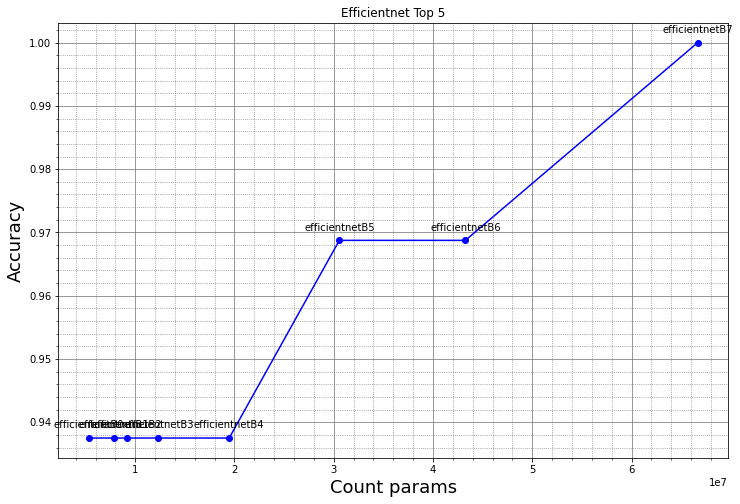

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns = ['Model Name' , 'Top1 accuracy', 'Top5 accuracy', 'Count params'])

xp = df['Count params']
yp = df['Top5 accuracy']
zp = df['Model Name']

fig, ax = plt.subplots()
plt.xlabel('Count params', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
ax.set_title('Efficientnet Top 5')
ax.grid(which='major', color = 'gray')
ax.grid(which='minor', color = 'gray', linestyle = ':')
ax.minorticks_on()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.plot(xp, yp,'bo-')
for x,y,z in zip(xp,yp,zp):
    label = "{}".format(z)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')


In [32]:
df

,Model Name,Top1 accuracy,Top5 accuracy,Count params
0,efficientnetB0,0.71875,0.93750,5330571
1,efficientnetB1,0.84375,0.93750,7856239
2,efficientnetB2,0.68750,0.93750,9177569
3,efficientnetB3,0.84375,0.93750,12320535
4,efficientnetB4,0.84375,0.93750,19466823
5,efficientnetB5,0.90625,0.96875,30562527
6,efficientnetB6,0.81250,0.96875,43265143
7,efficientnetB7,0.81250,1.00000,66658687
